### Imports

In [20]:
import pickle as pkl
import pandas as pd
import pandas
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec 
import rouge
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Activation, Bidirectional, Dropout, Input, concatenate, Reshape, TimeDistributed, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

### Loading Data

In [21]:
data = pd.read_pickle('data/tokenized.pkl')
eval_df = pd.read_pickle('data/evaluation.pkl')
data

,Unnamed: 0,publication,content
0,0,New York Times,"[washington, —, congressional, republicans, ha..."
1,1,New York Times,"[after, the, bullet, shells, get, the, south, ..."
2,2,New York Times,"[when, walt, disney, ’, s, but, what, they, di..."
3,3,New York Times,"[death, may, be, the, great, equalizer, ,, but..."
4,4,New York Times,"[seoul, ,, south, korea, —, although, north, k..."
...,...,...,...
47220,47220,BBC_tech,"[bt, is, introducing, two, initiatives, from, ..."
47221,47221,BBC_tech,"[computer, users, across, the, world, more, th..."
47222,47222,BBC_tech,"[a, new, european, directive, could, if, it, g..."
47223,47223,BBC_tech,"[the, man, making, sure, us, amit, yoran, was,..."


In [22]:
all_sentences = list(data['content'])
all_sentences.extend(list(eval_df['content']))

### Getting Relevant publications

In [23]:
# selected_publications = [
#  'Breitbart',
#  'CNN',
#  'New York Times',
#  'NPR',
#  'Fox News',
#  'Reuters']
selected_publications = [
 'Breitbart',
 'CNN',
 'New York Times']

In [24]:
all_publications = list(set(data['publication']))
all_publications

['Buzzfeed News',
 'Fox News',
 'New York Post',
 'BBC_entertainment',
 'Talking Points Memo',
 'Vox',
 'National Review',
 'BBC_sport',
 'Business Insider',
 'Guardian',
 'Reuters',
 'Breitbart',
 'BBC_politics',
 'New York Times',
 'BBC_tech',
 'BBC_business',
 'CNN',
 'NPR',
 'Washington Post',
 'Atlantic']

In [25]:
# Take only the contents from publications with >= 3000 samples.
publications = [pub for pub in selected_publications if pub in all_publications and len(data[data['publication'] == pub]) >= 3000]
publications

['Breitbart', 'CNN', 'New York Times']

In [26]:
contents = []
for pub in publications:
    contents.append(np.asarray(data[data['publication'] == pub]['content']))

### Padding with special Character

In [27]:
max_seq_length = max([len(seq) for content in contents for seq in content])
max_seq_length

50

In [28]:
end_token = '~?@_'

In [29]:
for content in contents:
    for seq in content:
        seq.extend([end_token] * (max_seq_length - len(seq)))

In [30]:
max_seq_length = max([len(seq) for content in contents for seq in content])
max_seq_length

50

### Vectorize Words

In [31]:
word_dim = 100

In [32]:

word2vec = gensim.models.Word2Vec(all_sentences, min_count = 1,  
                              size = word_dim, window = 5) 

In [33]:
print("Cosine similarity between 'congress' " + 
               "and 'senate' - CBOW : ", 
    word2vec.wv.similarity('congress', 'senate')) 
      
print("Cosine similarity between 'congress' " +
                 "and 'house' - CBOW : ", 
    word2vec.wv.similarity('congress', 'house')) 

Cosine similarity between 'congress' and 'senate' - CBOW :  0.74352306
Cosine similarity between 'congress' and 'house' - CBOW :  0.6554031


In [34]:
word2vec.wv['congressional']

array([-5.5864304e-01, -1.1151837e+00,  2.0400859e-01, -1.1860713e+00,
       -9.4131118e-01, -1.5206001e+00, -1.2306819e-01, -1.0624030e+00,
       -2.6075134e-01,  2.2947119e-01, -2.8813809e-01, -6.5101707e-01,
       -8.0437565e-01, -1.3439894e-01, -4.0379283e-01,  1.1511422e+00,
       -2.1832848e-02,  1.0486034e+00,  1.2868726e-01, -7.5674897e-01,
        1.0928172e+00,  5.7987660e-01,  1.0800809e+00, -6.3869613e-01,
       -3.0294910e-01, -1.0323806e-01, -6.8807399e-01,  1.5378779e-01,
       -5.8473939e-01, -6.8627989e-01,  8.5044044e-01, -6.2520212e-01,
       -2.6570415e-01,  7.6159221e-01,  3.2557079e-01, -2.5276494e-01,
        6.2459153e-01, -6.2127304e-01,  1.3832074e-01,  3.8336030e-01,
        5.7381684e-01,  3.6813083e-01, -1.1072714e-01, -5.6317610e-01,
        5.7922747e-02,  3.3037129e-01, -2.1762386e-01,  2.8589934e-01,
        9.0332210e-01, -2.2350942e-01,  2.8039858e-01,  3.6582494e-01,
        5.1231486e-01,  3.0246295e-02, -4.0461591e-01,  2.5360721e-01,
      

In [35]:
word2vec.wv.similar_by_vector(word2vec.wv['congressional'])

[('congressional', 0.9999999403953552),
 ('leaders', 0.8213309049606323),
 ('lawmakers', 0.8192103505134583),
 ('gop', 0.8126900792121887),
 ('voted', 0.8125409483909607),
 ('democratic', 0.8091769814491272),
 ('senate', 0.8070958852767944),
 ('judiciary', 0.8038367629051208),
 ('opposition', 0.7812871336936951),
 ('committee', 0.7728068828582764)]

In [36]:
contents = np.asarray(contents)

In [37]:
samples = np.zeros(shape=(contents.shape[0], contents.shape[1], max_seq_length, word_dim))

In [38]:
for i in range(contents.shape[0]):
    for j in range(contents.shape[1]):
        for k in range(max_seq_length):
            samples[i, j, k, :] = word2vec.wv[contents[i, j][k]]

## Funciton Definitions

In [39]:
def squareError(xTrue, xPred):
    return K.square(xTrue - xPred)


In [40]:
def reconstructionLoss(sample, encoder, decoder, f_w, weight): # (L_1 from the paper)
    return K.mean(squareError(sample, decoder(encoder(sample)))) + K.mean(weight*K.log(tf.clip_by_value(f_w(encoder(sample)),1e-10,1.0)))


In [41]:
def divergenceLoss(f_w, encoder, sample, z_j, n_j): # Mean of log f_w(E_theta_i(x_j)) + log (1-f_w(z_j, n_j)) from the paper (L_2).
    return K.mean(K.log(tf.clip_by_value(f_w(encoder(sample)),1e-10,1.0))) + K.mean(K.log(tf.clip_by_value(1 - f_w([z_j, n_j]),1e-10,1.0)))


In [42]:
def sample(data, domain, num_samples):
    N = data.shape[1]
    return tf.convert_to_tensor(data[domain, np.random.choice(N, num_samples, replace=True),:,:], dtype=tf.float32)


In [43]:
# Currently just doing a restriction to the last z variables, might want to do a matrix multiplication?
# pi_Z from the paper. projects a latent distribution in (z, n) to z
def projectZ(encoded):
    return encoded[0] # take zs.

In [44]:
def projectN(encoded):
    return encoded[1] # taek Ns.

In [45]:
# takes in two inputs, n and z, and outputs samples.
def createDecoder(z_dims, n_dims, time_steps, output_dims, lstm_dims):
    # TODO MAYBE: Add in more regularization or different than dropout?

    z_inputs = Input(shape=(z_dims,))
    n_inputs = Input(shape=(n_dims,))
    inputs = concatenate([z_inputs, n_inputs])
    dense = Dropout(0.2)(inputs)
#     # 150 is arbitrary rn...
#     dense = Dense(150)(inputs)
    dense = Dense(time_steps*output_dims)(dense)
    dense = Dropout(0.5)(dense)
    reshape = Reshape((time_steps, output_dims))(dense)
    # TODO Reshape to enforce time_steps?
    bilstm = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=True))(reshape)
    bilstm = Dropout(0.5)(bilstm)
    bilstm = LSTM(lstm_dims, activation='tanh', return_sequences=True)(bilstm)
#     bilstm = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=True))(bilstm)
#     bilstm = Dropout(0.5)(bilstm)
    
    outputs = TimeDistributed(Dense(output_dims, activation='linear'))(bilstm)
#     outputs = TimeDistributed(Dense(output_dims, activation='linear'))(bilstm)
    
    model = Model(inputs=[z_inputs, n_inputs], outputs=outputs)
    
    return model

In [46]:
def createEncoder(time_steps, input_num, z_dims, n_dims, lstm_dims):
    # TODO MAYBE: Add in more regularization or different than dropout?
    inputs = Input(shape=(time_steps, input_num,))
    bilstm = TimeDistributed(Dropout(0.2))(inputs)
#     bilstm = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=True))(bilstm)
#     bilstm = Dropout(0.5)(bilstm)
    dense = Bidirectional(LSTM(lstm_dims, activation='tanh', return_sequences=False))(bilstm)
    dense = Dropout(0.5)(dense)
    z_output = Dense(z_dims, activation='linear')(dense)
    n_output = Dense(n_dims, activation='linear')(dense)
    
    model = Model(inputs=inputs, outputs=[z_output, n_output])
    
    return model

In [47]:
def createDiscriminator(z_dims, n_dims):
    z_inputs = Input(shape=(z_dims,))
    n_inputs = Input(shape=(n_dims,))
    inputs = concatenate([z_inputs, n_inputs])
    
    dense = Dropout(0.2)(inputs)
    # 150, 100 is arbitrary rn...
    dense = Dense(150, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    dense = Dense(100, activation='relu')(dense)
    dense = Dropout(0.5)(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[z_inputs, n_inputs], outputs=output)
    
    return model

In [48]:
def plotLosses(domain, recLosses, divLosses):
    
    plt.figure(figsize=(16, 6))
    plt.rcParams.update({'font.size': 22})
    plt.title('Loss for Training Domain {} Autoencoder'.format(domain))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(recLosses)), recLosses, range(len(divLosses)), divLosses)
    plt.legend(['Reconstruction', 'Divergence'])
    plt.show()

### When $P_Z$ is known... 

In [49]:

# k is num of domains.
# encoders is a list of encoders.
# decoders is list of decoders.
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep
# original_domains is a list of the original domains P_z was derived from.

# Currently assuming P_Z is known. Must approximate P_Z first.
def trainAutoencodersWithPz(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=10, weight=1.0, lr = 3e-3):
    N = samples.shape[1]
    k = samples.shape[0]
        
    
    for i in range(k):
        if i not in original_domains:
            enc_optimizer = tf.keras.optimizers.Adam(lr)
            dec_optimizer = tf.keras.optimizers.Adam(lr)
            disc_optimizer = tf.keras.optimizers.Adam(lr)
            original_domain = np.random.choice(original_domains)
            encoder = encoders[i]
            decoder = decoders[i]
            original_encoder = encoders[original_domain]
            recLosses = []
            divLosses = []
            epoch = 0
            while(epoch < epochs): # could also do until some convergence criteria.
                p_Xi_samples = sample(samples, i, num_samples)
                p_Z_samples = projectZ(original_encoder(sample(samples, original_domain, num_samples)))
                p_Ni_samples = projectN(encoder(sample(samples, i, num_samples)))

                with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:

                    reconstruction_loss = reconstructionLoss(p_Xi_samples, encoder, decoder, discriminator, weight)

                    # negative b/c gradient ascent.
                    divergence_loss = -1 * divergenceLoss(discriminator, encoder, p_Xi_samples, p_Z_samples, p_Ni_samples)

                gradients_of_encoder = enc_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                gradients_of_decoder = dec_tape.gradient(reconstruction_loss, decoder.trainable_variables)
                gradients_of_discriminator = disc_tape.gradient(divergence_loss, discriminator.trainable_variables)
                
                enc_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
                dec_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
                disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                
                recLosses.append(reconstruction_loss)
                divLosses.append(divergence_loss)
                print('Domain {}, Epoch {}:\n\tReconstruction Loss: {}\n\tDivergence Loss: {}'.format(i, epoch+1, reconstruction_loss, divergence_loss))
                
                epoch+=1
            plotLosses(i, recLosses, divLosses)
            

### When $P_Z$ is unknown...
"A straight-forward approach for learning the latent distribution PZ is to train a regularized autoencoder on data from a
single representative domain. However, such a representation could potentially capture variability that is specific to
that one domain. To learn a more invariant latent representation, we propose the following extension of our autoencoder
framework. The basic idea is to alternate between training
multiple autoencoders until they agree on a latent representation that is effective for their respective domains. This is
particularly relevant for applications to biology; for example, often one is interested in learning a latent representation
that integrates all of the data modalities."

In [50]:

# k is num of domains.
# encoders is a list of encoders.
# decoders is list of decoders.
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep
# domains is a list of the domains we are currently training over.

def trainAutoencodersInitial(samples, encoders, decoders, discriminator, num_samples, domains, epochs=10, weight=1.0, lr = 3e-3):
    N = samples.shape[1]
    k = samples.shape[0]
    
    for i in domains:
        encoder = encoders[i]
        decoder = decoders[i]
        enc_optimizer = tf.keras.optimizers.Adam(lr)
        dec_optimizer = tf.keras.optimizers.Adam(lr)
        disc_optimizer = tf.keras.optimizers.Adam(lr)
        for j in domains:
            if i != j:
                j_encoder = encoders[j]
                recLosses = []
                divLosses = []
                epoch = 0
                while(epoch < epochs): # could also do until some convergence criteria.
                    p_Xi_samples = sample(samples, i, num_samples)
                    p_Zj_samples = projectZ(j_encoder(sample(samples, j, num_samples)))
                    p_Ni_samples = projectN(encoder(sample(samples, i, num_samples)))

                    with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:

                        reconstruction_loss = reconstructionLoss(p_Xi_samples, encoder, decoder, discriminator, weight)
                        #print(p_Xi_samples)

                        # negative b/c gradient ascent.
                        divergence_loss = -1 * divergenceLoss(discriminator, encoder, p_Xi_samples, p_Zj_samples, p_Ni_samples)
                        
                    gradients_of_encoder = enc_tape.gradient(reconstruction_loss, encoder.trainable_variables)
                    gradients_of_decoder = dec_tape.gradient(reconstruction_loss, decoder.trainable_variables)
                    gradients_of_discriminator = disc_tape.gradient(divergence_loss, discriminator.trainable_variables)
            

                    enc_optimizer.apply_gradients(zip(gradients_of_encoder, encoder.trainable_variables))
                    dec_optimizer.apply_gradients(zip(gradients_of_decoder, decoder.trainable_variables))
                    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
                
                    recLosses.append(reconstruction_loss)
                    divLosses.append(divergence_loss)
                    
                    print('Domain {}, Epoch {}:\n\tReconstruction Loss: {}\n\tDivergence Loss: {}'.format(i, epoch+1, reconstruction_loss, divergence_loss))
                    epoch+=1
                plotLosses(i, recLosses, divLosses)
            

In [51]:
# samples is a K x N x Timesteps x dim, array of samples, where the 0th index is the domain,
# the 1th index is the # of the sample in that domain, 2th index is the # timesteps per sequence, 3th index is the #
# of dimensions at each timestep

def initModel(samples, z_dims, n_dims, lstm_dims):
    
    k = samples.shape[0]
    N = samples.shape[1]
    time_steps = samples.shape[2]
    dim = samples.shape[3]
    
    
    
    discriminator = createDiscriminator(z_dims, n_dims)
    
    encoders = []
    decoders = []
    
    for i in range(k):
        encoders.append(createEncoder(time_steps, dim, z_dims, n_dims, lstm_dims))
        decoders.append(createDecoder(z_dims, n_dims, time_steps, dim, lstm_dims))
    
    return encoders, decoders, discriminator

In [52]:
def translate(start_sequences, samples, encoders, decoders, start_domain, end_domain):
    N = samples.shape[1]
    print(start_sequences.shape)
    num_samples = start_sequences.shape[0]
    
    start_encoder = encoders[start_domain]
    end_encoder = encoders[end_domain]
    end_decoder = decoders[end_domain]
    
    z = projectZ(start_encoder(start_sequences))
    n = projectN(end_encoder(sample(samples, end_domain, num_samples)))
    
    end_sequences = end_decoder([z, n])
    return end_sequences
    

In [69]:
def vecSeqToSentence(sequence):
    sequence = K.eval(sequence)
    sentence = []
    for i in range(sequence.shape[0]):
        word = sequence[i,:]
        #print(word)
        #print(word2vec.wv.similar_by_vector(word))
        sentence.append(word2vec.wv.similar_by_vector(word)[0][0])
    return sentence
    print(sentence)

In [54]:
n_dims = 100 # len(n)
z_dims = 100 # len(Z)

lstm_dims = 64

num_epochs = 1
num_samples = 128

weight = 1

lr = 3e-3

original_domains = [0, 1]



In [55]:
encoders, decoders, discriminator = initModel(samples, z_dims, n_dims, lstm_dims)

### Original First Sentence from 0

In [56]:
' '.join(contents[0, 0])

'on tuesday ’ s broadcast ” zeleny said , “ and she ’ s having a difficult time in federal prison , no question . ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_ ~?@_'

In [57]:
seq = tf.convert_to_tensor(np.asarray([samples[0, 0, :, :]]), dtype=tf.float32)
translation = translate(seq, samples, encoders, decoders, original_domains[0], original_domains[1])

(1, 50, 100)


### Original First Sentence from 0 translated to 1 before Training (Random)

In [58]:

vecSeqToSentence(translation[0,:,:])


['legislatures', 'legislatures', 'superficially', 'occurring', 'occurring', 'occurring', 'presidencies', 'presidencies', 'sexploitive', 'shoplifting', 'shoplifting', 'rigging', 'triaged', 'pao', 'pao', 'pao', 'zaid', 'zaid', 'nl2n1h01gv', 'monomoy', 'langford', 'langford', 'blurted', 'reparations', 'reparations', 'takim', 'takim', 'belam', 'belam', 'jef', 'jef', 'jahn', 'redskin', 'redskin', 'hauntingness', 'hauntingness', '10:10', 'soccerex', 'zolle', 'unfiltered', 'unfiltered', 'quizzing', 'quizzing', 'tenet', 'tenet', 'egoism', 'egoism', 'tenet', 'tenet', 'tenet']


Domain 0, Epoch 1:
	Reconstruction Loss: 0.1958116888999939
	Divergence Loss: 1.4230246543884277


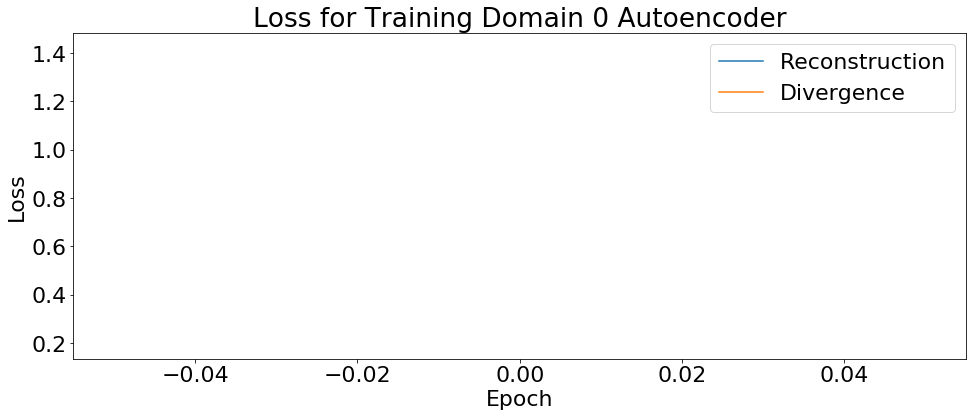

Domain 1, Epoch 1:
	Reconstruction Loss: -0.06160980463027954
	Divergence Loss: 1.5582704544067383


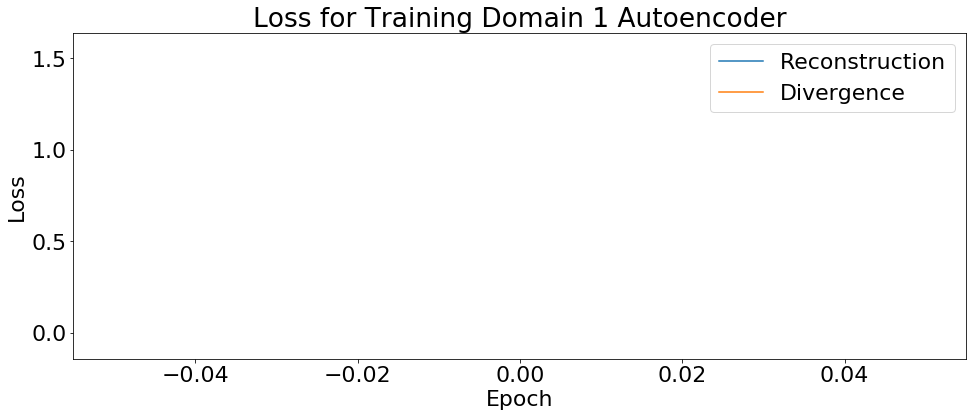

In [59]:
trainAutoencodersInitial(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=num_epochs, weight=weight, lr = lr)


### Original First Sentence from 0 translated to 1 after training

In [60]:
translation = translate(seq, samples, encoders, decoders, original_domains[0], original_domains[1])
vecSeqToSentence(translation[0,:,:])

(1, 50, 100)
['beforehand', 'beforehand', 'announcer', 'announcer', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'improbability', 'mayberry', 'mayberry', 'mayberry', 'mayberry', 'mayberry', 'mayberry', 'mayberry', 'inlcuded', 'inlcuded', 'inlcuded', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'superexcited', 'mayberry', 'presidencies', 'presidencies', 'presidencies', 'presidencies', 'presidencies', 'presidencies']


Domain 2, Epoch 1:
	Reconstruction Loss: 0.04053843021392822
	Divergence Loss: 1.2497344017028809


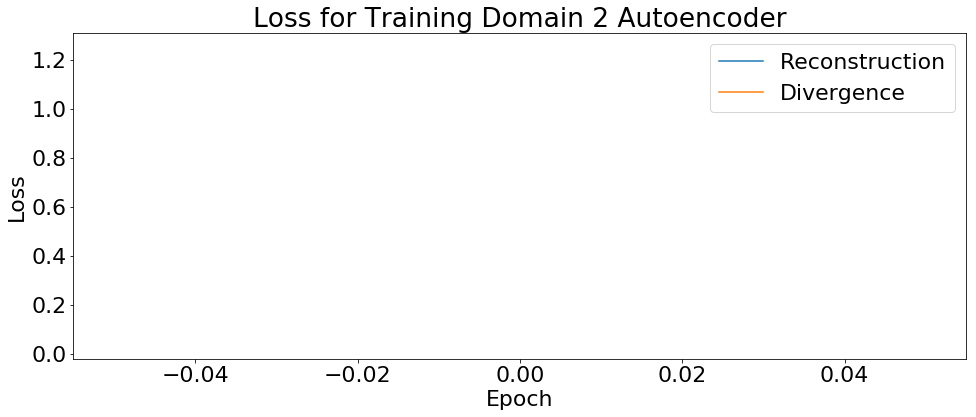

In [61]:
trainAutoencodersWithPz(samples, encoders, decoders, discriminator, num_samples, original_domains, epochs=num_epochs, weight=weight, lr = lr)


### Original First Sentence from 0 translated to 2 after Training

In [62]:
translation = translate(seq, samples, encoders, decoders, 0, 2)
vecSeqToSentence(translation[0,:,:])

(1, 50, 100)
['tis', 'tis', 'delight', 'today', 'today', 'today', 'crawling', 'crawling', 'crawling', 'delight', 'delight', 'delight', 'delight', 'delight', 'delight', 'delight', 'delight', 'delight', 'delight', 'delight', 'suggestively', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'betrayal', 'betrayal', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'veiled', 'yamamoto', 'oof', 'kisses', 'kisses', 'kisses', 'kisses', 'veiled', 'veiled']


## All Translations

In [84]:
for i in range(len(selected_publications)):
        for j in range(len(selected_publications)):
            if (i != j):
                pub1=publications[i]
                pub2=publications[j]
                
                encoder = encoders[i]
                decoder = decoders[j]
                
                source_article = samples[i][0:1]
                
                translated = decoder(encoder(tf.convert_to_tensor(source_article, dtype=tf.float32)))
                
                print(pub1,"to",pub2)
                print("\t",detok.detokenize(vecSeqToSentence(source_article[0])))
                print("\nto\n")
                print("\t",detok.detokenize(vecSeqToSentence(translated[0])))
                

Breitbart to CNN
	 while barack obama ’ s justice department is “ fighting efforts to prevent from voting illegally, ” the new york times reports that the open borders spanish language network univision, which will no doubt serve as a super pac for hillary clinton this year (univision is by
to
	 ~?@_ ~?@_ improbable improbable protege swore moira moira moira renounces renounces inevitability inevitability inevitability charlatan cowards irna locke locke locke locke xm ðÿ‚ ðÿ‚ nonchalantly nonchalantly nonchalantly nonchalantly nonchalantly ðÿ‚ ðÿ‚ ðÿ‚ sikhs sikhs sikhs sikhs melons purplerain purplerain prevailing prevailing prevailing prevailing prevailing naika naika prevailing rectangle prevailing prevailing
Breitbart to New York Times
	 while barack obama ’ s justice department is “ fighting efforts to prevent from voting illegally, ” the new york times reports that the open borders spanish language network univision, which will no doubt serve as a super pac for hillary clinton thi

## Evaluation with Rouge

In [63]:
eval_df

,Unnamed: 0,publication,content
0,0,New York Times,"[it, is, called, the, heimlich, maneuver, —, s..."
1,1,New York Times,"[after, all, the, allegations, of, rampant, vo..."
2,2,New York Times,"[zsa, zsa, gabor, ,, the, hungarian, actress, ..."
3,3,New York Times,"[russia, ’, s, ambassador, to, turkey, ,, andr..."
4,4,New York Times,"[san, francisco, —, following, directions, fro..."
...,...,...,...
5995,5995,BBC_tech,"[bt, is, introducing, two, initiatives, to, he..."
5996,5996,BBC_tech,"[computer, users, across, the, world, continue..."
5997,5997,BBC_tech,"[a, new, european, directive, could, put, soft..."
5998,5998,BBC_tech,"[the, man, making, sure, us, computer, network..."


In [64]:
contents = []
for pub in publications:
    contents.append(np.asarray(eval_df[eval_df['publication'] == pub]['content']))
    
for content in contents:
    for seq in content:
        seq.extend([end_token] * (max_seq_length - len(seq)))
    
contents = np.asarray(contents)
samples = np.zeros(shape=(contents.shape[0], contents.shape[1], max_seq_length, word_dim))

for i in range(contents.shape[0]):
    for j in range(contents.shape[1]):
        for k in range(max_seq_length):
            samples[i, j, k, :] = word2vec.wv[contents[i, j][k]]

In [71]:
detok = TreebankWordDetokenizer()

evaluator = rouge.Rouge(metrics=['rouge-n', 'rouge-l', 'rouge-w'],
                        max_n=4,
                        limit_length=True,
                        length_limit=100,
                        length_limit_type='words',
                        apply_avg=False,
                        apply_best=True,
                        alpha=0.5, # Default F1_score
                        weight_factor=1.2,
                        stemming=True
                       )

In [72]:
def evaluateOnArticles(articles, encoder, decoder):
    translated = decoder(encoder(tf.convert_to_tensor(articles, dtype=tf.float32)))
       
    original_sentences = [detok.detokenize(vecSeqToSentence(tokens)) for tokens in articles]
    
    translated_sentences = [detok.detokenize(vecSeqToSentence(tokens)) for tokens in translated]
    
    scores = evaluator.get_scores(translated_sentences, original_sentences)
    
    for metric, results in sorted(scores.items(), key=lambda x: x[0]):
        print('\t{}:\t{}: {:5.2f}\t{}: {:5.2f}\t{}: {:5.2f}'.format(metric, 'P', 100.0 * results['p'], 'R', 100.0 * results['r'], 'F1', 100.0 * results['f']))

In [73]:
def evaluate(articles, encoders, decoders):
    
    for i in range(len(selected_publications)):
        for j in range(len(selected_publications)):
            if (i != j):
                pub1=publications[i]
                pub2=publications[j]
                #source_articles = articles_df.loc[articles_df['publication'] == pub1]['content'].tolist()
                source_articles = articles[i]
                
                print(pub1,"to",pub2)
                evaluateOnArticles(source_articles, encoders[i], decoders[j])
                print()

In [74]:
evaluate(samples, encoders, decoders)

Breitbart to CNN
	rouge-1:	P:  0.14	R:  0.23	F1:  0.17
	rouge-2:	P:  0.00	R:  0.00	F1:  0.00
	rouge-3:	P:  0.00	R:  0.00	F1:  0.00
	rouge-4:	P:  0.00	R:  0.00	F1:  0.00
	rouge-l:	P:  0.25	R:  0.37	F1:  0.29
	rouge-w:	P:  0.13	R:  0.11	F1:  0.11

Breitbart to New York Times
	rouge-1:	P:  0.11	R:  0.19	F1:  0.13
	rouge-2:	P:  0.00	R:  0.00	F1:  0.00
	rouge-3:	P:  0.00	R:  0.00	F1:  0.00
	rouge-4:	P:  0.00	R:  0.00	F1:  0.00
	rouge-l:	P:  0.21	R:  0.33	F1:  0.25
	rouge-w:	P:  0.11	R:  0.10	F1:  0.10

CNN to Breitbart


KeyboardInterrupt: 